# Response time minimization - Agder police district

### Version 4.0

- Goal: Minimize the response time of police vehicles to events within police district.
- The problem is formulated as a capacitated vehicle positioning problem using PuLP.


#### Agder police district
Agder police district is one of 12 police districts in Norway. It covers the entire Agder county and are responsible for 25 municipalities, with approx. 300,000 inhabitants.

In [1]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-04-18T12:35:59.020158+02:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shapely.geometry import Point, MultiPolygon
from descartes import PolygonPatch
import geopandas as gpd
import osmnx as ox
import pandana as pdna
import utilityModule # custom functions

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

geopandas : 0.14.3
numpy     : 1.26.4
matplotlib: 3.8.3
pandana   : 0.7
pandas    : 2.2.1
osmnx     : 1.9.1



## 0. Load road network

We load a preprocessed graph (road network) from file. This has been prepared using the corresponding preprocessing script.  
The graph is a MultiDiGraph clipped after the boundaries of Oslo police district. Imported as WGS84 (EGSG:4326) and will be converted to UTM33N (EPSG:32633) before the analysis.  
Network node centrality has been computed and saved locally. Edges contain road speeds and travel times. Road speeds have been increased by 20-40% to simulate police vehicle speeds.

In [3]:
### Load road network from file
Agder_filepath = "../data/Agder/AgderDriveImputed.graphml" # with travel time attribute
Agder_graph = ox.load_graphml(Agder_filepath) # originally in WGS84 (EPSG:4326)

In [4]:
Agder_graph = ox.projection.project_graph(Agder_graph, to_crs='EPSG:32633') # project to local UTM zone
print(f"Type of Agder_graph: {type(Agder_graph)}")
print(f"CRS of Agder_graph:  {Agder_graph.graph['crs']}")

# plot graph
# fig, ax = ox.plot_graph(Agder_graph, node_size=1, edge_linewidth=0.2, edge_color="w", bgcolor="k")

Type of Agder_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of Agder_graph:  EPSG:32633


Convert MultiDiGraph to node and edge GeoDataFrames.

In [5]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(Agder_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes)}")
# nodes.head()
edges.head(2) # verify edges contain speed and travel time

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


osmid      highway  oneway reversed  \
u        v          key                                                         
10620171 4742796138 0                 481340888  residential   False    False   
         4742796105 0    [798640507, 481340862]    secondary   False    False   

                         length  \
u        v          key           
10620171 4742796138 0    37.260   
         4742796105 0   374.330   

                                                                  geometry  \
u        v          key                                                      
10620171 4742796138 0    LINESTRING (62633.100 6458567.396, 62632.264 6...   
         4742796105 0    LINESTRING (62633.100 6458567.396, 62662.101 6...   

                         speed_kph  travel_time   ref            name  \
u        v          key                                                 
10620171 4742796138 0       33.000        4.100   NaN             NaN   
         4742796105 0       55.000       24.500  3972  Harkmarksveien   

                         maxspeed bridge lanes junction tunnel access service  \
u        v          key                                                         
10620171 4742796138 0         NaN    NaN   NaN      NaN    NaN    NaN     NaN   
         4742796105 0    [60, 50]    NaN   NaN      NaN    NaN    NaN     NaN   

                        width  
u        v          key        
10620171 4742796138 0     NaN  
         4742796105 0     NaN

Increase road speeds by 20-40% to simulate more realistic police vehicle speeds. Increased speed ($y$) is computed based on the original speed ($x$) using a 3rd degree polynomial function:  
$y = 0.0000232614692 * x^3 + 0.00692679011 * x^2 + 0.836197811 * x + 5.20808653$

- For 20 kph, increased speed is 24.52 kph (22.58% increase)
- For 70 kph, increased speed is 89.70 kph (28.15% increase)
- For 110 kph, increased speed is 150.04 kph (36.40% increase)

In [6]:
# increase speed of edges
edges_increased = utilityModule.increase_edge_speeds(edges)
edges_increased.head(2) # verify increased edge speeds and shorter travel times

osmid      highway  oneway reversed  \
u        v          key                                                         
10620171 4742796138 0                 481340888  residential   False    False   
         4742796105 0    [798640507, 481340862]    secondary   False    False   

                         length  \
u        v          key           
10620171 4742796138 0    37.260   
         4742796105 0   374.330   

                                                                  geometry  \
u        v          key                                                      
10620171 4742796138 0    LINESTRING (62633.100 6458567.396, 62632.264 6...   
         4742796105 0    LINESTRING (62633.100 6458567.396, 62662.101 6...   

                         speed_kph  travel_time   ref            name  \
u        v          key                                                 
10620171 4742796138 0       39.510        3.395   NaN             NaN   
         4742796105 0       68.282       19.736  3972  Harkmarksveien   

                         maxspeed bridge lanes junction tunnel access service  \
u        v          key                                                         
10620171 4742796138 0         NaN    NaN   NaN      NaN    NaN    NaN     NaN   
         4742796105 0    [60, 50]    NaN   NaN      NaN    NaN    NaN     NaN   

                        width  
u        v          key        
10620171 4742796138 0     NaN  
         4742796105 0     NaN

In [7]:
# recombining nodes and increased edges to MultiDiGraph format
Agder_graph_increased = ox.graph_from_gdfs(nodes, edges_increased)

## 1. Simulate event points

Steps:  
1.1 Load preprocessed population data  
1.2 Event simulation based on population count.  
1.3 Snap points to network (after defined Pandana network)  

### 1.1 Load preprocessed population data  

We load preprocessed population data in 250x250m grid cells from SSB.

In [8]:
# load preprocessed polygon data and convert to CRS UTM zone 33N (EPSG:32633)
Agder_polygon_path = "../data/Agder/AgderCombinedPolygon.geojson"
Agder_polygon_gdf = gpd.read_file(Agder_polygon_path)
Agder_polygon_gdf = Agder_polygon_gdf.to_crs(Agder_graph.graph['crs']) # convert to same CRS as the road network

In [9]:
# load preprocessed population data and convert to CRS UTM zone 33N (EPSG:32633)
population_path = "../data/Agder/AgderPopulation.geojson"
population_gdf = gpd.read_file(population_path)
population_gdf = population_gdf.to_crs(Agder_graph.graph['crs']) # convert to same CRS as the road network

In [10]:
print(f"type of pop_df: {type(population_gdf)}")
print(f"columns of population_gdf: {population_gdf.columns}")
population_gdf.head(2)

type of pop_df: <class 'geopandas.geodataframe.GeoDataFrame'>
columns of population_gdf: Index(['id', 'population', 'geometry'], dtype='object')


id  population  \
0  20850006461500          63   
1  20852506461500         164   

                                            geometry  
0  POLYGON ((85000.001 6461499.999, 85000.001 646...  
1  POLYGON ((85250.001 6461499.999, 85250.001 646...

### 1.2 Event simulation based on population counts

For each gridcell, simulated events are generated based on the population count and scaled with a self-adjustable factor that ensure the total number of simulated events will fall in the preferred range.

In [11]:
# calculate the number of points to simulate in each grid cell - vectorized version
# population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=1500, max_range=1550) # few events, fast testing
population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=1800, max_range=1900) # std pop multiplier
# standard population multiplier: 0.008347656250000002

# # print the number of cells with 0, 1, 2, ..., 9 events
# for i in range(0, 7):
#     print(f"Nr of cells with {i} events: {len(population_gdf[population_gdf['num_points'] == i])}")

# print the cells with the highest number of points
population_gdf.nlargest(3, 'num_points')

Total number of simulated event points: 1862. Target range [1800, 1900], using population multiplier: 0.008347656250000002


id  population  \
9943  20882506466250         679   
9979  20880006466500         716   
9972  20882506466500         617   

                                               geometry  num_points  
9943  POLYGON ((88250.001 6466249.999, 88250.001 646...           6  
9979  POLYGON ((88000.001 6466499.999, 88000.001 646...           6  
9972  POLYGON ((88250.001 6466499.999, 88250.001 646...           5

In [12]:
# List to hold all generated points
event_points = []
# Iterate over rows in your GeoDataFrame
for _, row in population_gdf.iterrows():
    # Extract number of points to generate for the current row
    num_points = row['num_points']
    if num_points > 0:  # Proceed only if there are points to generate
        # Generate points within the grid cell 
        points = utilityModule.generate_points_within_gridcell(num_points, row['geometry'].bounds)
        event_points.extend(points)

# Create a GeoDataFrame from the generated points
event_points_gdf = gpd.GeoDataFrame(geometry=event_points, crs=population_gdf.crs)
event_points_gdf.head(3)

geometry
0  POINT (85095.678 6461565.896)
1  POINT (85286.180 6461572.041)
2  POINT (84756.289 6461812.552)

In [13]:
# create polygons around high event density areas
high_pop_density_area = utilityModule.generate_high_density_polygon(event_points_gdf, grid_size=100, 
                        density_threshold=5.5e-11, simplification_tolerance=5.0, plot_results=False)

Density: Min: 4.287e-40 | Median: 2.125e-14 | Mean: 3.342e-11 | Max: 1.368e-09


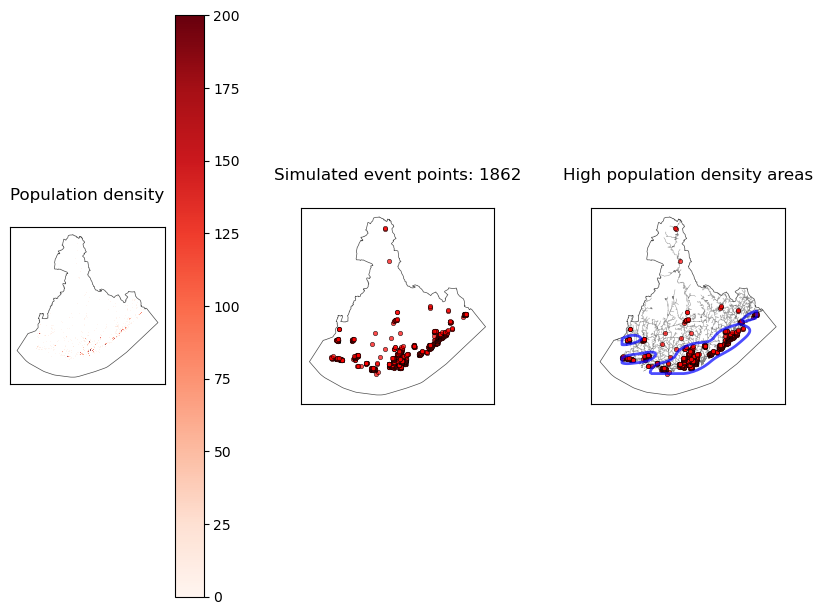

In [14]:
# Plot the population density, simulated event points, and high population density areas side-by-side
utilityModule.plot_population_density_and_event_points(Agder_polygon_gdf, population_gdf, 
                                                       event_points_gdf, high_pop_density_area, edges)

## 2. Police car candidate points

Steps:  
2.1 Add Centrality measures as node attributes  
2.2 Sample candidate points and filter out best candidate points

### 2.1 Add Centrality measure as node attribute

Closeness centrality is a measure of how close a node is to all other nodes in the network.  
Betweenness centrality is a measure of how many shortest paths pass through a node.

In [15]:
# if centrality is in the nodes GeoDataFrame, drop it
if 'closeness_centrality' in nodes.columns:
    nodes.drop(columns=['closeness_centrality'], inplace=True)
if 'betweenness_centrality' in nodes.columns:
    nodes.drop(columns=['betweenness_centrality'], inplace=True)

# import node closeness centrality from file
nodes_centrality_import = pd.read_csv("../data/Agder/AgderNodeCentrality.csv")

# Since 'osmid' is the index in `nodes`, we can merge on the index
nodes = nodes.merge(nodes_centrality_import, left_index=True, right_on='osmid')

# After the merge, if you want 'osmid' as a column instead of an index, can reset the index
nodes.reset_index(drop=True, inplace=True)
nodes.set_index('osmid', inplace=True)
nodes.head(2)

y         x  street_count   lon    lat highway  ref  \
osmid                                                                      
10620171   6458567.396 62633.100             3 7.581 58.052     NaN  NaN   
4742796138 6458531.514 62639.492             1 7.581 58.052     NaN  NaN   

                                 geometry  closeness_centrality  \
osmid                                                             
10620171    POINT (62633.100 6458567.396)                 0.000   
4742796138  POINT (62639.492 6458531.514)                 0.000   

            betweenness_centrality  
osmid                               
10620171              14143501.000  
4742796138                   0.000

### 2.2 Sample candidate points and filter out best candidate points

In [16]:
# random nodes from the graph
SEED = 2
NR_OF_CAR_NODES = 100

# sample X random source nodes from the area high_pop_density_area
car_nodes = nodes[nodes.within(high_pop_density_area.geometry.values[0])]
car_nodes = car_nodes.sample(NR_OF_CAR_NODES, random_state=SEED) # sample X random source nodes
print(f"Total nr of nodes: {len(nodes)}, nr of police car nodes: {len(car_nodes)}")

# make car_nodes into a GeoDataFrame
car_nodes_gdf = gpd.GeoDataFrame(car_nodes, geometry=gpd.points_from_xy(car_nodes.x, car_nodes.y))
car_nodes.head(2)

Total nr of nodes: 34686, nr of police car nodes: 100


y          x  street_count   lon    lat highway  ref  \
osmid                                                                       
4377731532 6498994.702 137327.101             1 8.775 58.480     NaN  NaN   
4395735732 6472282.294 107848.899             1 8.319 58.216     NaN  NaN   

                                  geometry  closeness_centrality  \
osmid                                                              
4377731532  POINT (137327.101 6498994.702)                 0.000   
4395735732  POINT (107848.899 6472282.294)                 0.000   

            betweenness_centrality  
osmid                               
4377731532                   0.000  
4395735732                   0.000

Input nr of car nodes: 100
Remaining nr of car nodes: 80, after discarding the 20 (20%) remote car nodes with lowest closeness centrality
Centrality Measure: closeness


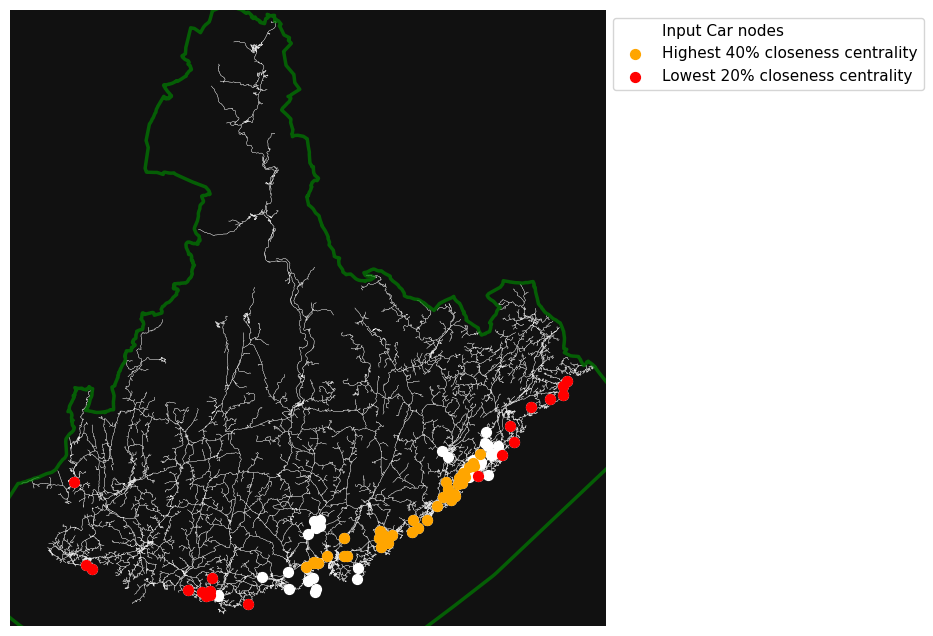

In [17]:
# Filter Car nodes by closeness centrality
car_nodes_gdf_central1 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf, district_boundary=Agder_polygon_gdf, 
                    top_percent=0.4, bottom_percent=0.20, input_graph=Agder_graph, centrality_measure="closeness", plot=True)

Input nr of car nodes: 80
Remaining nr of car nodes: 64, after discarding the 16 (20%) remote car nodes with lowest betweenness centrality
Centrality Measure: betweenness


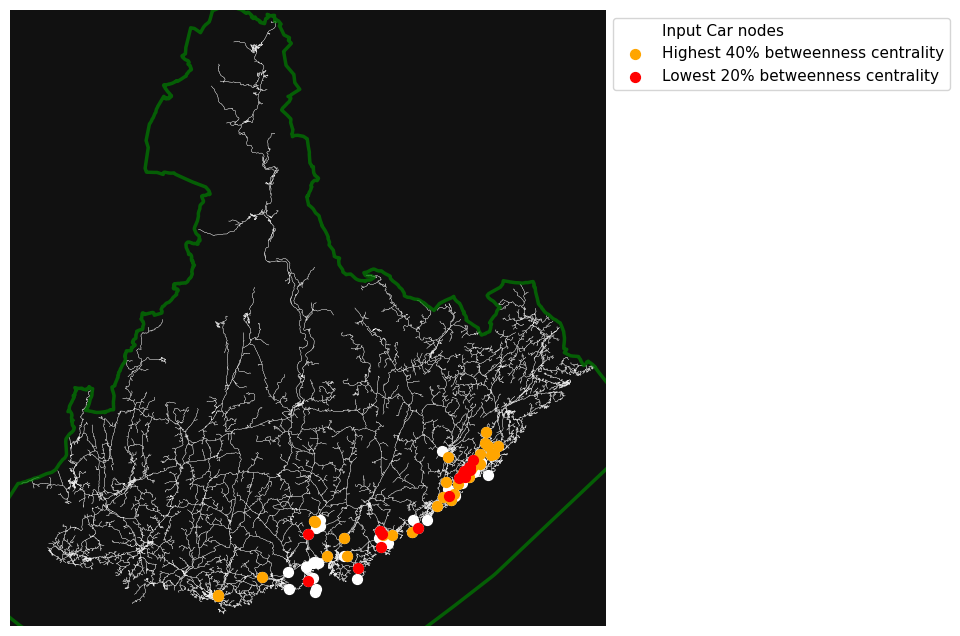

In [18]:
# Filter Car nodes by betweenness centrality
car_nodes_gdf_central2 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf_central1, district_boundary=Agder_polygon_gdf, 
                            top_percent=0.4, bottom_percent=0.20, input_graph=Agder_graph, centrality_measure="betweenness", plot=True)

Input nr of car nodes: 64
Remaining nr of car nodes: 37, after removing the 27 nodes that are within 2000 m of each other



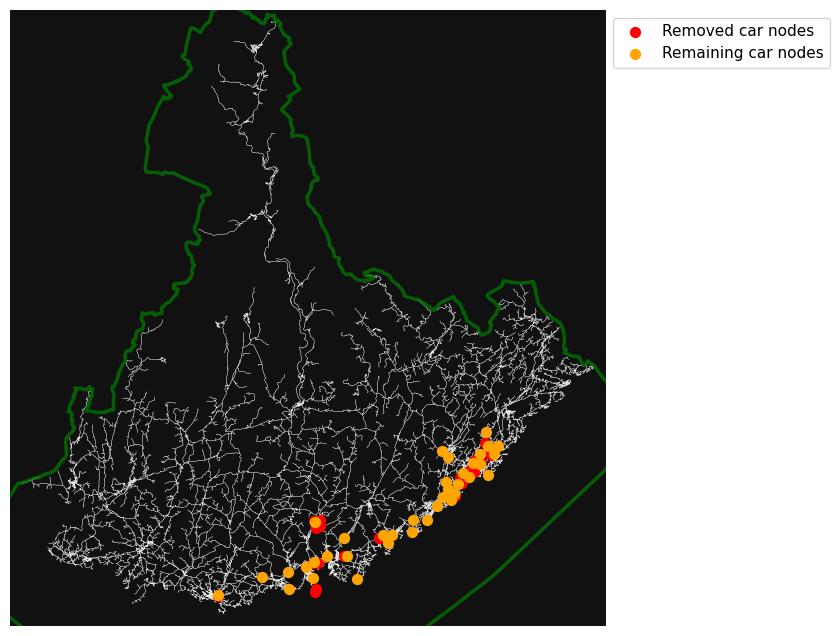

In [19]:
# Filter Car nodes by proximity to each other
car_nodes_gdf_filtered = utilityModule.filter_nodes_by_proximity(geo_df=car_nodes_gdf_central2, district_boundary=Agder_polygon_gdf, 
                             min_distance=2000, input_graph=Agder_graph, criterion_col='betweenness_centrality', prefer='higher', plot=True)

## 3. Define the Pandana network

We use the GeoDataFrames from `osmnx` to create a `pandana` network with both ``length`` and ``travel_time`` as edge weights.  
We have to specify which one to use when querying the network (cannot calculate with both at the same time).

In [20]:
# reset index so our origins and destinations are not in index
edges = edges_increased.reset_index() # increased edge speed
# edges = edges.reset_index()         # original edge speed
# nodes = nodes.reset_index()

# create network with pandana
Agder_network_pdna = pdna.Network(node_x=nodes['x'], node_y=nodes['y'], edge_from=edges['u'], edge_to=edges['v'], 
                                      edge_weights=edges[["length", "travel_time"]], twoway=True)

# Print stats about the network
print(f"type of Agder_network_pdna: {type(Agder_network_pdna)}")
print(f"Network nodes:")
Agder_network_pdna.nodes_df.head(2)

type of Agder_network_pdna: <class 'pandana.network.Network'>
Network nodes:


x           y
osmid                           
10620171   62633.100 6458567.396
4742796138 62639.492 6458531.514

In [21]:
print(f"Network edges: ")
Agder_network_pdna.edges_df.head(2)

Network edges: 


from          to  length  travel_time
0  10620171  4742796138  37.260        3.395
1  10620171  4742796105 374.330       19.736

Recall that the Car Nodes were directly sampled from the road network, while event points were generated outside the road network.  
Therefore, we need to snap the event points to the Pandana network.

In [22]:
# identify nearest node to each event point
event_points_gdf['nearest_node'] = Agder_network_pdna.get_node_ids(event_points_gdf.geometry.x, event_points_gdf.geometry.y, mapping_distance=1000)

# With nearest_node attribute, find osm x,y coordinates
event_points_gdf = event_points_gdf.merge(nodes[['x', 'y']], left_on='nearest_node', right_index=True, suffixes=('', '_nearest_node'))
event_points_gdf.head(2)

geometry  nearest_node         x           y
0  POINT (85095.678 6461565.896)    5485312695 85023.004 6461574.103
1  POINT (85286.180 6461572.041)    2173996795 85202.500 6461583.603

In [23]:
# Get list of nearest node ids for event locations
event_nodes_pdna = Agder_network_pdna.get_node_ids(x_col=event_points_gdf.geometry.x, y_col=event_points_gdf.geometry.y).values
event_nodes_pdna[:5]

# get the nearest node ids (in this case, just selecting the 'osmid')
car_nodes_pdna = Agder_network_pdna.get_node_ids(x_col=car_nodes_gdf_filtered.x, y_col=car_nodes_gdf_filtered.y).values
car_nodes_pdna[:5]

array([ 431164235, 7830441527, 6543573890, 4377728743, 4397835116],
      dtype=int64)

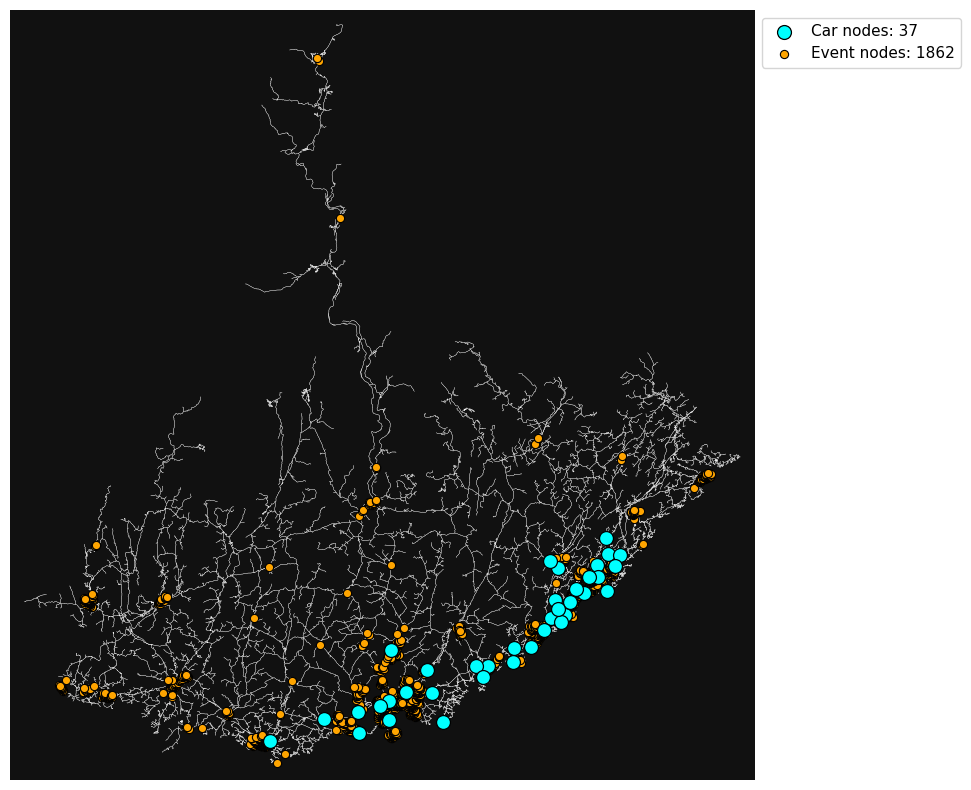

In [24]:
# Plot overview of Car nodes and Event nodes
fig, ax = ox.plot_graph(Agder_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False, figsize=(10,10))
ax.scatter(car_nodes_gdf_filtered['x'], car_nodes_gdf_filtered['y'], c='cyan', edgecolor='black', lw=0.90, s=100, label=f"Car nodes: {len(car_nodes_gdf_filtered)}", zorder=3)
ax.scatter(event_points_gdf['x'], event_points_gdf['y'], c='orange', s=35, edgecolor='black', lw=0.80, label=f"Event nodes: {len(event_points_gdf)}", zorder=2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)
plt.show()

## 4. Cost Matrix - Calculate all origin-destination pairs

Building Cost Matrix:
- Cross-join all events and car locations to get all possible origin-destination pairs.
- Compute the travel time of each combination using Pandana `shortest_path_lengths()`

In [25]:
# Creating origins-destination pairs
origins = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
destinations = np.tile(event_nodes_pdna, len(car_nodes_pdna))

In [26]:
%%time
# travel time between each possible pair of car-event combination
distances = Agder_network_pdna.shortest_path_lengths(origins, destinations, imp_name='length')
travel_times = Agder_network_pdna.shortest_path_lengths(origins, destinations, imp_name='travel_time')
print(f"{len(car_nodes_pdna)} origins x {len(event_nodes_pdna)} destinations = {len(origins)} origin-destination pairs (problem size)\n")
print("5 first origin-destination distances [m]     :", distances[:5])
print("5 first origin-destination travel times [sec]:", travel_times[:5])

37 origins x 1862 destinations = 68894 origin-destination pairs (problem size)

5 first origin-destination distances [m]     : [56126.467, 55917.657, 56164.931, 55981.696, 56002.245]
5 first origin-destination travel times [sec]: [1868.722, 1852.096, 1874.048, 1855.673, 1857.733]
CPU times: total: 2.7 s
Wall time: 303 ms


In [27]:
# describe statistics for travel times - horizontally
travel_times_df = pd.DataFrame(travel_times) / 60 # in minutes
travel_times_df.describe().T

count   mean    std   min    25%    50%    75%     max
0 68894.000 31.399 20.922 0.000 15.456 28.311 41.593 149.650

In [28]:
# Restructure the distances and travel times arrays into a DataFrame (CAgder Matrix) and add the car and event node ids as columns
# create a DataFrame from the distances and travel times arrays
CostMatrix = pd.DataFrame({'distance': distances, 'travel_time': travel_times})

# add the car and event node ids as columns
CostMatrix['carNodeID'] = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
CostMatrix['eventNodeID'] = np.tile(event_nodes_pdna, len(car_nodes_pdna))
# CostMatrix.head() # distances, travel times, car and event node ids

# merge the distances DataFrame with the car and event nodes DataFrames to get the coordinates
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='carNodeID', right_index=True, suffixes=('', '_car'))
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='eventNodeID', right_index=True, suffixes=('', '_event'))
CostMatrix_extended.head(2) # distances, travel times, car and event node coordinates

distance  travel_time  carNodeID  eventNodeID         x           y
0 56126.467     1868.722  431164235   5485312695 85023.004 6461574.103
1 55917.657     1852.096  431164235   2173996795 85202.500 6461583.603

In [29]:
CostMatrix_extended.head(2) # distances, travel times, car and event node coordinates

distance  travel_time  carNodeID  eventNodeID         x           y
0 56126.467     1868.722  431164235   5485312695 85023.004 6461574.103
1 55917.657     1852.096  431164235   2173996795 85202.500 6461583.603

In [30]:
# Save cAgder matrix to CSV
CostMatrix.to_csv("../data/Agder/AgderCostMatrix.csv", index=False)

# drop the distance column from the CostMatrix, just using travel time
CostMatrix.drop(columns="distance", inplace=True)

We have 2 Cost Matrices with distances and travel times between each police car and event node pair.
- ``CostMatrix`` is the lean cost matrix that will be used for further computations in optimization problems. - *saved as local .csv file for later use*
- ``CostMatrix_extended`` is the cost matrix extended with coordinate information. Useful for post-optimization tasks.

# 5. Optimization problem

### 5.1 Formulating the problem
We will use the Python library PuLP to model and solve the optimization problem.   
The objective is to minimize the total response time to events, by optimally positioning a fixed number of police cars.

#### Notation
- $N$ : The set of all nodes in the road network.
- $E$ : The set of events locations, a subset of $N$.
- $P$ : The set of potential police car locations, a subset of $N$.
- $C_{ij}$ : The travel time from police car location $i \in P$ to event location $j \in E$.
- $x_i$ : Binary decision variable where $x_i = 1$ if a police car is positioned at node $i$, and $x_i = 0$ otherwise.
- $y_{ij}$ : Binary decision variable where $y_{ij} = 1$ if the event $j$ is assigned to the police car located at $i$, and $y_{ij} = 0$ otherwise.
- $K$ : The number of police cars available.
- $M$ : The maximum number of events that can be assigned to a police car.

#### Objective Function
The objective is to minimize the total response time to all events. The response time is the travel time from a police car to an event, considering only the assignments where $y_{ij} = 1$.
$$
\text{Minimize} \quad Z = \sum_{i \in P} C_{ij} \cdot y_{ij}
$$

#### Constraints
1. **Police Car Placement Constraint**: Only $K$ police cars are available to be deployed.
$$
\sum_{i \in P} x_i = K
$$

2. **Event Assignment Constraint**: Each event must be assigned to exactly one police car.
$$
\sum_{i \in P} y_{ij} = 1 \quad \forall j \in E
$$

3. **Validity Constraint**: An event can only be assigned to a police car if that car is positioned at a node.
$$
y_{ij} \leq x_i \quad \forall i \in P, \forall j \in E
$$

4. **Capacity Constraint**: Each police car can only be assigned to a limited number of events.
$$
\sum_{j \in E} y_{ij} \leq M \cdot x_i \quad \forall i \in P
$$

5. **Non-Negativity and Integrality**: Ensure that the decision variables are binary.
$$
x_i \in \{0, 1\} \quad \forall i \in P
$$
$$
y_{ij} \in \{0, 1\} \quad \forall i \in P, \forall j \in E
$$


### 5.2 Preprocessing data for efficient computation
0) Add suffixes to eventNodeID's to preserve events that share same network nodes
1) Convert the cost matrix to a dictionary for faster iteration speed.
2) Reduce CostMatrix by filtering out the top X% travel times, as there probably is another closer car to the event. (optional)

In [31]:
# add suffix to duplicate eventNodeIDs
CostMatrix_suffix = utilityModule.suffix_duplicate_nodes(CostMatrix)
CostMatrix_suffix.head(2)

travel_time  carNodeID   eventNodeID
0     1868.722  431164235  5485312695_1
1     1852.096  431164235  2173996795_1

In [32]:
### Problem Setup parameters
# Problem reduction
DISCARD_THRESHOLD = 0.00

# Constants
NR_OF_CARS = 4
margin = len(event_nodes_pdna) * 0.03 # 3% of all events
CAR_CAPACITY = (len(event_nodes_pdna) // NR_OF_CARS) + round(margin)
print(f"Car capacity: {CAR_CAPACITY} events per car")

# # Sets
P = CostMatrix_suffix['carNodeID'].unique()  # All car locations
E = CostMatrix_suffix['eventNodeID'].unique()  # Events
nr_of_unique_events = len(E)
# Preprocess the cost matrix: convert to dict and reduce problem size
CostMatrix_dict_reduced = utilityModule.preprocess_cost_matrix(CostMatrix_suffix, discard_threshold=DISCARD_THRESHOLD, verbose=True)

Car capacity: 521 events per car
Filtering out 0% highest travel times - keeping only travel times <= 8979 sec, or 149.7 min
Original nr of pairs: 68894 | Filtered nr of pairs: 68894
Original max travel time: 8979.016 | Filtered max travel time: 8979.016


### 5.2 Setup LP problem

In [33]:
%%time
# Define PuLP problem
problem = utilityModule.define_pulp_problem(CostMatrix_suffix, CostMatrix_dict_reduced, 
    nr_of_cars=NR_OF_CARS, car_capacity=CAR_CAPACITY, problem_name="PoliceCarLocationOptimization", verbose=True)

Number of police car locations: 37
Number of events: 1862
Number of decision variables: 68931
Number of constraints: 70794
Number of non-zero coefficients: 68931
Number of non-zero coefficients in the objective function: 68891
CPU times: total: 2.83 s
Wall time: 3.53 s


### 5.5 Run solver - PULP_CBC (COIN-OR Branch and Cut)

The solver is first run with relaxed integer variable constraint (`mip=False`) for fast computation.  
If the solver does not find all integer solutions, it is run again use proper integer constraints (`mip=True`).

In [34]:
%%time
# Run the solver
print(f"(Note: Currently reducing the Cost matrix by {DISCARD_THRESHOLD*100:.0f}%)")
solve = utilityModule.run_solvers(problem, P, nr_of_locations=NR_OF_CARS, 
                                solver_name='PULP_CBC_CMD', forceMIP=False, plot=False)

(Note: Currently reducing the Cost matrix by 0%)
PULP_CBC_CMD with LP relaxation found 3/4 locations in 26.22 seconds.
Switching to MILP solver configuration to find optimal solution.

Optimal police car locations found: 4/4 in 240.93 seconds: [7830441527 4377728449 5235276382 5498678007]
Solver: PULP_CBC_CMD | Status: 1 (Optimal)
Objective function value (total response time): 1232526.7840 seconds, or 20542.11 minutes, or 342.37 hours
CPU times: total: 11.4 s
Wall time: 4min 37s


### 5.6 Extract results for inspection

In [35]:
# Extract optimal police car locations
optimal_locations = {i: problem.variablesDict()[f"x_{i}"].varValue for i in P if problem.variablesDict()[f"x_{i}"].varValue == 1}
print("Optimal police car locations:", optimal_locations.keys())

# convert to geodataframe for plotting. Should contain the carNodeID and the geometry (Point)
optimal_locations_gdf = gpd.GeoDataFrame(geometry=[Point(nodes.loc[node, 'x'], nodes.loc[node, 'y']) for node in optimal_locations.keys()], crs="EPSG:32633")
optimal_locations_gdf['carNodeID'] = optimal_locations.keys()
carNodeID_list = list(optimal_locations_gdf['carNodeID'])

car_to_events_df = utilityModule.create_car_to_events_df(CostMatrix_extended, optimal_locations, problem, 
                                                         CAR_CAPACITY, nr_of_unique_events, verbose=True)
car_to_events_df.to_csv("../data/Agder/AgderCarToEventsAssignment.csv", index=False) # export the car to events assignment to CSV

Optimal police car locations: dict_keys([7830441527, 4377728449, 5235276382, 5498678007])
Car 7830441527 is assigned 299/521 events
Car 4377728449 is assigned 521/521 events
Car 5235276382 is assigned 521/521 events
Car 5498678007 is assigned 521/521 events
Summing the events for each car gives 1862 events, which should equal the total number of unique events: 1862


## 6. Visualization

### 6.1 Plot the optimal police car locations and events

Input parameters:
- Possible police car locations: 37 | Optimal locations in solution: 4
- Events: 1862 | Max event capacity per police car: 521

Solution from Linear Programming (LP) model:
Goal: minimize objective function (total response time)
Objective function value: 1232527 sec | 20542.1 min | 342.37 hours

Car id: 7830441527 handles 299 events | Capacity: 57.39% | Total response time: 7125.69 min | Median: 23.39 min | Avg: 23.83 min
Car id: 4377728449 handles 521 events | Capacity: 100.00% | Total response time: 5248.30 min | Median: 9.32 min | Avg: 10.07 min
Car id: 5235276382 handles 521 events | Capacity: 100.00% | Total response time: 4189.95 min | Median: 5.68 min | Avg: 8.04 min
Car id: 5498678007 handles 521 events | Capacity: 100.00% | Total response time: 3978.17 min | Median: 4.96 min | Avg: 7.64 min


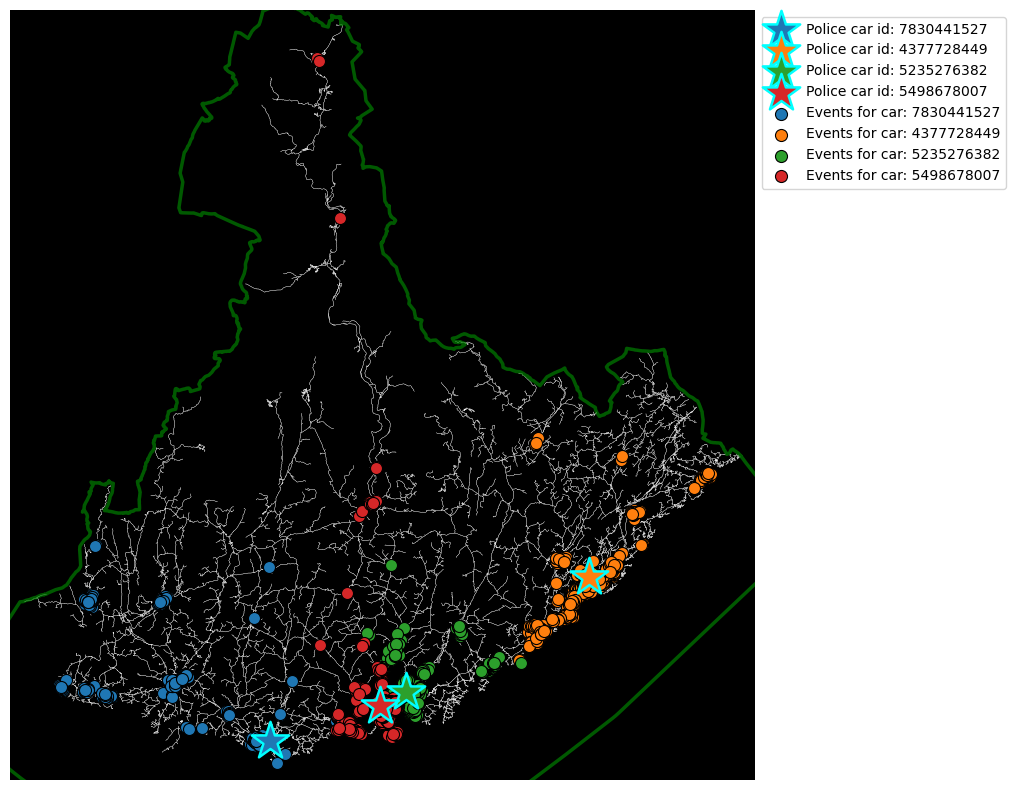

CPU times: total: 4.28 s
Wall time: 5.19 s


In [36]:
%%time
# Plot the optimal car locations and the assigned events
utilityModule.plot_optimal_allocations(Agder_graph, Agder_polygon_gdf, optimal_locations_gdf, car_to_events_df, 
                car_nodes_gdf_filtered, nr_of_unique_events, NR_OF_CARS, CAR_CAPACITY, problem, figsize=(10,10))

## 6.2 Visualize Isochrones - reach in different time intervals
We visualize the collective reach of the police cars in the district with different time intervals.  
We plot isochrones as buffers to get more faithful isochrones than convex hulls can offer.

In [37]:
# Define how many trip times to visualize
TRIP_TIMES = [15, 40, 120]  # in minutes
ISO_COLORS = ['royalblue', 'magenta', 'yellow']  # Long, Middle, Short ranges

In [38]:
%%time
# Generate isochrone polygons
isochrone_polys = utilityModule.make_iso_polys(Agder_graph_increased, TRIP_TIMES, carNodeID_list, 
                                                edge_buff=350, node_buff=0, infill=True)
# Merge isochrones
merged_isochrones = utilityModule.merge_isochrones(isochrone_polys)

CPU times: total: 2min 24s
Wall time: 2min 59s


Isochrone polygons for the travel times: [15, 40, 120] minutes


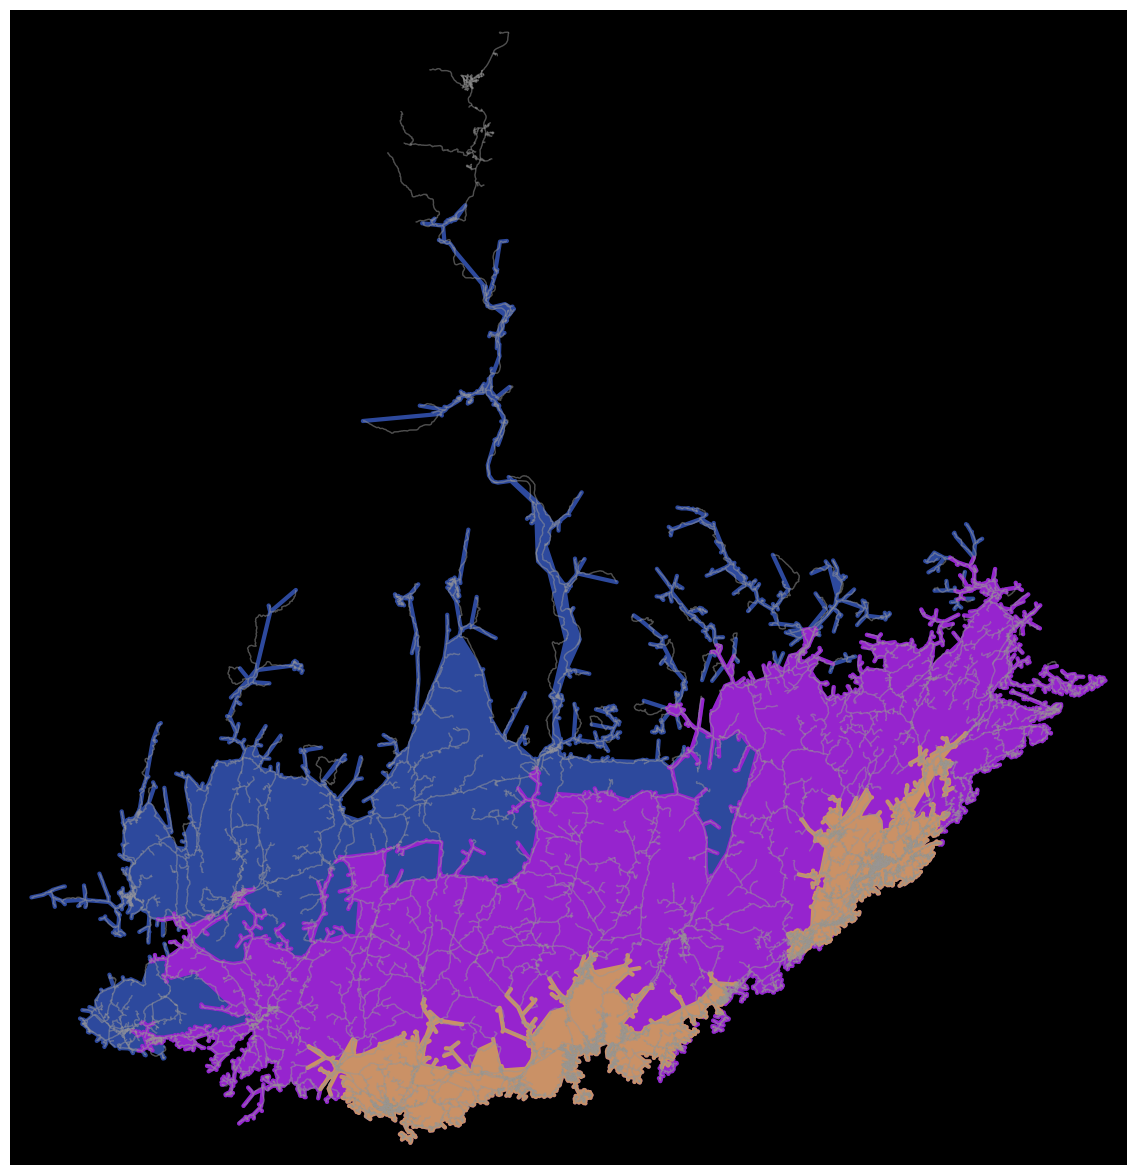

In [39]:
# Plotting the graph and merged isochrones
fig, ax = ox.plot_graph(Agder_graph_increased, show=False, close=False, edge_color='#999999', 
                        edge_alpha=0.3, node_size=0, bgcolor='k', figsize=(15, 15))

# Plotting merged isochrones with colors
for i, (merged_poly, color) in enumerate(zip([merged_isochrones[0], merged_isochrones[1], merged_isochrones[2]], ISO_COLORS)):
    alpha_value = 0.7 if i == 0 else 0.5  # less transparent long-range(i=0)
    if isinstance(merged_poly, MultiPolygon):
        for poly in merged_poly.geoms:
            patch = PolygonPatch(poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
            ax.add_patch(patch)
    else:
        patch = PolygonPatch(merged_poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
        ax.add_patch(patch)
print("Isochrone polygons for the travel times:", TRIP_TIMES, "minutes")
plt.show()

### 6.3 Visualize isochrones on interactive map

In [40]:
# Plot leaflet map
isochrone_map = utilityModule.plot_leaflet_map(Agder_graph, TRIP_TIMES, merged_isochrones, Agder_polygon_gdf, background_poly=True)
isochrone_map